In [1]:
from openparticle.hamiltonians import *
from openparticle import ParticleOperator, Fock
from openparticle.utils import get_fock_basis, generate_matrix
import numpy as np
from openparticle.dlcq import *
from itertools import combinations
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "Times New Roman"
plt.rc('text', usetex=True)

In [2]:
def get_sign(op):
    return 1 if op.creation else -1

def get_mass(op, m_F, m_B):
    if op.particle_type == 'fermion':
        return m_F
    elif op.particle_type == 'antifermion':
        return m_F
    elif op.particle_type == 'boson':
        return m_B
    
def get_momentum(op):
    if op.particle_type == 'fermion' or op.particle_type == 'antifermion':
        return p(op.mode + 1/2)
    elif op.particle_type == 'boson':
        return p(op.mode + 1)

def renorm_Yukawa_first_order(Lambda, t, m_F = 1, m_B = 1):
    H1 = three_point_yukawa(Lambda)

    ren_H1 = ParticleOperator({})

    for term in H1.to_list():
        exp_factor = 0
        for op in term.split():
            exp_factor += get_sign(op) * get_mass(op, m_F, m_B)**2 * 1/get_momentum(op)
        ren_H1 += np.exp(-exp_factor**2 * t) * term

    return ren_H1

def renorm_Yukawa_second_order(Lambda, t, m_F = 1, m_B = 1):
    H1inst = instantaneous_yukawa(Lambda)

    ren_H1inst = ParticleOperator({})

    for term in H1inst.to_list():
        exp_factor = 0
        for op in term.split():
            exp_factor += get_sign(op) * get_mass(op, m_F, m_B)**2 * 1/get_momentum(op)
        ren_H1inst += np.exp(-exp_factor**2 * t) * term

    return ren_H1inst


In [3]:
# def renormalized_Yukawa(Lambda, t):
#     return free_boson_Hamiltonian(Lambda) + free_fermion_Hamiltonian(Lambda) + renorm_Yukawa_first_order(Lambda, t) + \
#         renorm_Yukawa_second_order(Lambda, t)

In [34]:
def kamil(op, basis):
    size = (len(basis), len(basis))
    matrix = np.zeros(size, dtype=complex)

    for j, state_j in enumerate(basis):
        rhs = op * state_j
        for i, state_i in enumerate(basis):
            if j <= i:  # only calculate lower triangular elements
                if rhs.op_dict == {}:
                    val = 0
                else:
                    val = (state_i.dagger() * ParticleOperator(rhs.op_dict)).VEV()
                matrix[i][j] = matrix[j][i] = val
    return matrix

In [35]:
def plot_m2_vs_pp(Pplus_val, Lambda, coupling = 1):

    print("Generating Hamiltonian...")
    ham = yukawa_Hamiltonian(Lambda = Lambda, g = coupling)
    print("Hamiltonian generated.")
    evals = []
    pplus_arr = [i for i in range(0, Pplus_val + 1)]


    for pp in pplus_arr:
        print("--- P+: ", pp, "---")
        print("Partitioning... ")
        pp_tmp_basis = Pplus_states_partition(pp)
        print("Generating ",len(pp_tmp_basis), "x", len(pp_tmp_basis)  ," matrix...")
        tmp_mat = kamil(ham, pp_tmp_basis)
        print("Computing eigenvalues...")
        evals.append(min(np.linalg.eigvalsh(tmp_mat)) * pp)

    # return evals, pplus_arr
    # # return evals, pplus_arr
    plt.figure(figsize=(3,3), dpi = 200)
    plt.scatter(pplus_arr[1:], np.array(evals)[1:], marker='.')
    # plt.yscale('symlog')
    plt.xlabel(f'$\Lambda$')
    plt.ylabel(f'$M^2$')
    plt.tight_layout()
    # plt.savefig('yukawa_spectrum.jpg')
    plt.show()

Generating Hamiltonian...
Hamiltonian generated.
--- P+:  0 ---
Partitioning... 
Generating  1 x 1  matrix...
Computing eigenvalues...
--- P+:  1 ---
Partitioning... 
Generating  2 x 2  matrix...
Computing eigenvalues...
--- P+:  2 ---
Partitioning... 
Generating  7 x 7  matrix...
Computing eigenvalues...
--- P+:  3 ---
Partitioning... 
Generating  14 x 14  matrix...
Computing eigenvalues...
--- P+:  4 ---
Partitioning... 
Generating  30 x 30  matrix...
Computing eigenvalues...
--- P+:  5 ---
Partitioning... 
Generating  56 x 56  matrix...
Computing eigenvalues...
--- P+:  6 ---
Partitioning... 
Generating  105 x 105  matrix...
Computing eigenvalues...
--- P+:  7 ---
Partitioning... 
Generating  182 x 182  matrix...
Computing eigenvalues...


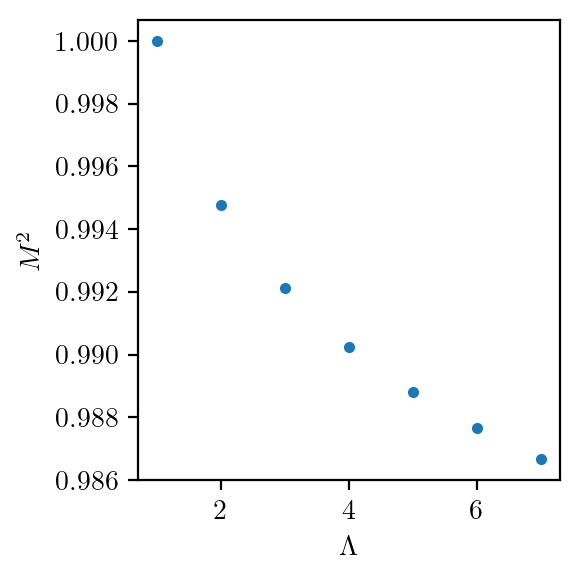

In [39]:
cut = 7
plot_m2_vs_pp(Pplus_val=cut, Lambda=cut, coupling = 0.2)

### Partition $H$ into blocks of definite $P^+$

Text(0.5, 1.0, '$\\Lambda = 3$')

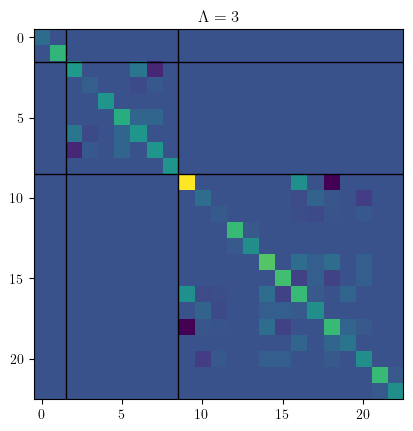

In [41]:
t = 1
pp = 3
basis = [Pplus_states_partition(i)[j] for i in range(1, pp + 1) for j in range(len(Pplus_states_partition(i)))]
plt.imshow(
    np.real(
        generate_matrix(yukawa_Hamiltonian(pp, g = 1), basis)
    )
)
n_states_i = 0
for i in range(1, pp):
    n_states_i += len(Pplus_states_partition(i))
    plt.axvline(x=n_states_i - 0.5, color='black', linewidth=1)
    plt.axhline(y=n_states_i - 0.5, color='black', linewidth=1)

plt.title(f'$\Lambda = {pp}$')

## New $\mathcal{O}(g^2)$ Diagrams

In [42]:
Lambda = 4
g = 1
L = 1
t = 0.1
m_F = 1
m_B = 0.01

### Fermion Current $J(x)$

$$
\tilde J(q) = g \int_{-\infty}^\infty \int_{-\infty}^\infty \frac{dq_1^+dq_2^+}{(4\pi)^2}\delta(q + q_1 - q_2):\tilde \psi^\dagger(q_1)\gamma^0 \tilde \psi(q_2):
$$

$$
C_\phi = \int_0^\infty \frac{dq^+}{4\pi|q^+|}:\tilde J(-q) \tilde J(q):
$$

$
C_\phi = g\int_0^\infty \frac{dq^+}{4\pi|q^+|}\int_{-\infty}^\infty\int_{-\infty}^\infty\int_{-\infty}^\infty\int_{-\infty}^\infty \frac{dq_1^+dq_2^+dq_{1'}^+dq_{2'}^+}{(4\pi)^4}\delta(-q + q_1 - q_2)\delta(q + q_{1'} - q_{2'}):\tilde \psi^\dagger(q_{1'})\gamma^0 \tilde \psi(q_{2'})::\tilde \psi^\dagger(q_{1})\gamma^0 \tilde \psi(q_{2}):
$

$$
B = \frac{1}{2}\left(\frac{1}{q_1^- - q_2^- - q^-} + \frac{1}{q_{1'}^- - q_{2'}^- - q^-} \right)\left(e^{-(q_1^- - q_2^- - q^-)^2t}e^{-(q_{1'}^- - q_{2'}^- - q^-)^2t} - e^{-(q_1^- + q_2^- - q_{1'}^- - q_{2'}^-)^2t} \right)
$$

In [43]:
Cphi = ParticleOperator({})

for q in np.arange(1, Lambda, 1):
    for q1p in np.arange(-Lambda + 1/2, Lambda, 1):
        for q2p in np.arange(-Lambda + 1/2, Lambda, 1):
            for q1 in np.arange(-Lambda + 1/2, Lambda, 1):
                for q2 in np.arange(-Lambda + 1/2, Lambda, 1):
                    if -q + q1 - q2 == 0 and q + q1p - q2p == 0:
                        q1minus = m_F**2 / q1
                        q2minus = m_F**2 / q2

                        q1pminus = m_F**2 / q1p
                        q2pminus = m_F**2 / q2p

                        qminus = m_B**2 / q
                        
                        A = q1minus - q2minus - qminus
                        B = q1pminus - q2pminus - qminus
                        C = q1minus + q2minus - q1pminus - q2pminus

                        B = 0.5 * (
                            1/A + 1/B
                        )* (
                            np.exp(-A**2 * t) * np.exp(-B**2 * t) - np.exp(-C**2 * t)
                        )
                        op_L = (
                            FermionField(q1p).psi_dagger.dot(gamma0.dot(FermionField(q2p).psi))
                        )[0][0]
                        op_R = (
                            FermionField(q1).psi_dagger.dot(gamma0.dot(FermionField(q2).psi))
                        )[0][0]
                        Cphi += B * op_L * op_R

Cphi = remove_symmetry_terms(Cphi.normal_order(), 4)

In [44]:
Cphi

9.515907050574227e-07 * d2^ d3^ d3 d2
-0.11912912851625623 * d2^ d1^ d3 d0
0.3790545394303842 * b1^ b0 d2^ d3
0.04752077912869902 * b2^ b1 d2^ d3
6.158698761766694e-05 * b3^ b2 d2^ d3
2.289302397492006e-06 * d1^ d2^ d2 d1
0.25217447637790735 * b1^ b0 d1^ d2
5.6983196707664995e-05 * b2^ b1 d1^ d2
-0.04734994585228302 * b3^ b2 d1^ d2
0.11892983668548937 * d0^ d3^ d1 d2
1.2126767409604839e-05 * d0^ d1^ d1 d0
2.6360832209856862e-05 * b1^ b0 d0^ d1
-0.2519440499923623 * b2^ b1 d0^ d1
-0.37835456164769826 * b3^ b2 d0^ d1
-0.37835456164769826 * b0^ b1 d3^ d2
-0.2519440499923622 * b0^ b1 d2^ d1
2.6360832209856862e-05 * b0^ b1 d1^ d0
1.2126767409604839e-05 * b0^ b1^ b1 b0
0.11892983668548937 * b0^ b3^ b1 b2
-0.04734994585228302 * b1^ b2 d3^ d2
5.6983196707664995e-05 * b1^ b2 d2^ d1
0.25217447637790735 * b1^ b2 d1^ d0
2.289302397492006e-06 * b1^ b2^ b2 b1
6.158698761766694e-05 * b2^ b3 d3^ d2
0.04752077912869902 * b2^ b3 d2^ d1
0.3790545394303842 * b2^ b3 d1^ d0
-0.11912912851625623 * b2^ b1^ b3

In [45]:
def cfree(x, m = 1):
    return m**2 / p(x)

def c(x, y, z, L = 1):
    return 2 * L * ubar(p(x)).dot(u(p(y)))[0][0] * (x == y + z)

def cstar(x, y, z, L = 1):
    return 2 * L * ubar(p(x)).dot(u(p(y)))[0][0] * (x + z == y)

def cbar(x, y, z, L = 1):
    return 2 * L * vbar(p(y)).dot(v(p(x)))[0][0] * (x == y + z)

def cbarstar(x, y, z, L = 1):
    return 2 * L * vbar(p(y)).dot(v(p(x)))[0][0] * (x + z == y)

def ctilde(x, y, z, L = 1):
    return 2 * L * ubar(p(x)).dot(v(p(y)))[0][0] * (x + y == z)

def ctildestar(x, y, z, L = 1):
    return 2 * L * vbar(p(y)).dot(u(p(x)))[0][0] * (x + y == z)

In [49]:
#T channel interactions

t_channel = ParticleOperator({})

for k in np.arange(1, Lambda, 1):
    for i in np.arange(1/2, Lambda, 1):
        for ip in np.arange(1/2, Lambda, 1):
            for j in np.arange(1/2, Lambda, 1):
                for jp in np.arange(1/2, Lambda, 1):
                    num = (
                        cfree(ip, m_F) + cfree(j, m_F) - cfree(i, m_F) - cfree(jp, m_F) - 2*cfree(k, m_B)
                        ) * cstar(i, ip, k) * c(j, jp, k)
                   
                    den = (
                        cfree(i, m_F) + cfree(k, m_B) - cfree(ip, m_F) 
                    )**2 + (
                        cfree(j, m_F) - cfree(jp, m_F) - cfree(k, m_B) 
                    )**2 + (
                        cfree(i, m_F) + cfree(j, m_F) - cfree(ip, m_F) - cfree(jp, m_F)
                    )**2

                    exp = (
                        np.exp(-(
                        cfree(i, m_F) + cfree(j, m_F) - cfree(ip, m_F) - cfree(jp, m_F)
                    )**2 * t) - np.exp(-((
                        cfree(i, m_F) + cfree(k, m_B) - cfree(ip, m_F) 
                    )**2 + (
                        cfree(j, m_F) - cfree(jp, m_F) - cfree(k, m_B) 
                    )**2)*t
                    )
                    )
                    string2 = 'b' + str(int(i - 1/2)) + "^ " + 'b' + str(int(j - 1/2)) + "^ " + 'b' + str(int(ip - 1/2)) + ' b' + str(int(jp - 1/2))

                    t_channel += (num/den * exp) * ParticleOperator(string2)

t_channel

-0.901416762369233 * b0^ b1^ b1 b0
-0.11530676404700699 * b0^ b2^ b1 b1
-0.040022831424594646 * b0^ b3^ b1 b2
-0.11530676404700699 * b1^ b1^ b2 b0
-0.1448945703594968 * b1^ b2^ b2 b1
-0.05772492614400556 * b1^ b3^ b2 b2
-0.040022831424594646 * b2^ b1^ b3 b0
-0.05772492614400557 * b2^ b2^ b3 b1
-0.05991864192671786 * b2^ b3^ b3 b2
-1.457346527324971 * b0^ b2^ b2 b0
-0.2136778746639247 * b0^ b3^ b2 b1
-0.21367787466392466 * b1^ b2^ b3 b0
-0.23091855571637016 * b1^ b3^ b3 b1
-1.9808641779240688 * b0^ b3^ b3 b0

$$
B = \frac{1}{2}\left(\frac{1}{q_L - q^-} + \frac{1}{q_R - q^-} \right)\left(e^{-(q_L - q^-)^2t}e^{-(q_R - q^-)^2t} - e^{-(q_L - q_R)^2t} \right)
$$

$$
q_L = q + q_1
$$

$$
q_R = q' + q_2
$$

In [ ]:
Cj = ParticleOperator({})

for q in np.arange(1, Lambda, 1):
    for qp in np.arange(1, Lambda, 1):
        for q1 in np.arange(-Lambda + 1/2, Lambda + 1, 1):
            for q2 in np.arange(-Lambda + 1/2, Lambda + 1, 1):
                if q1 + q - qp - q2 == 0:
                    qL = q + q1
                    qR = qp + q2
                    B = 0.5 * (
                        1/(qL - q) + 1/(qR - q)
                    ) * (
                        np.exp(-(qL - q)**2 * t) * np.exp(-(qR - q)**2 * t) - np.exp(-(qL - qR)**2 * t)
                    )

                    curlyP_plus = q1 + q
                    middle = 0.5 * gammap * m_F**2 / curlyP_plus + 0.5 * gammam * curlyP_plus
                    Cj += B * FermionField(q1).psi_dagger.dot(gamma0.dot(middle.dot(FermionField(q2).psi)))[0][0] * (
                        ScalarField(-q).phi * ScalarField(qp).phi
                    )
Cj = remove_symmetry_terms(Cj.normal_order(), 4)
                    

In [ ]:
Cphi

In [ ]:
Cj

### Fermion Loop Diagram

$$
H^{(2)}_{\delta_{m_F}}(t) = \int_{ijk} \frac{|c_{ijk}(0)|^2}{c_i - c_j - c_k}\left(1 - e^{-2(c_i - c_j - c_k)^2t} \right)b_i^\dagger b_i + \chi_{\delta_{m_F}}
$$

In [ ]:
Lambda = 1000
t = 1

result = ParticleOperator({})
for k1 in np.arange(1/2, Lambda, 1):
    loop = ParticleOperator({})
    for k2 in np.arange(1/2, Lambda, 1):
        # for k3 in np.arange(1, Lambda, 1):
        k3 = k1 - k2
        if k3 > 0:
            measure = 1 / (p(k1) * p(k2) * p(k3))

            Cnum = np.abs(2 * L * m_F * (p(k1) + p(k2)) / np.sqrt(p(k1) * p(k2)))**2
            Cden = m_F**2 / p(k1) - m_F**2 / p(k2) - m_B**2 / p(k3)
            C = Cnum/Cden

            exp = (1 - np.exp(-2 * Cden**2 * t))
            # exp = 1

            index = str(int(k1 - 0.5))
            loop +=  measure * C * exp * ParticleOperator('b' + index + '^ ' + 'b' + index)
    result += g**2 / (2*L)**3 * loop
result
# plt.plot(np.arange(1/2, Lambda - 1, 1),np.abs(result.coeffs))
# plt.xscale('log')
# plt.yscale('log')